# EEE 197z Project 1 - Zero Shot Object Detection
use SAM to perform zero-shot object detection using COCO 2017 val split. 

*Author: Sean Red Mendoza | 2020-01751 | scmendoza5@up.edu.ph*

## Tools/ References
- [SegmentAnything](https://github.com/facebookresearch/segment-anything)
- [OpenClip](https://github.com/mlfoundations/open_clip)
- [Coco 2017 Validation Dataset](https://cocodataset.org/#home)
- [roatienza/mlops](https://github.com/roatienza/mlops)
- [roatienza/Deep-Learning-Experiments](https://github.com/roatienza/Deep-Learning-Experiments)
- [Google Cloud G2 GPU VM (Nvidia L4)](https://cloud.google.com/blog/products/compute/introducing-g2-vms-with-nvidia-l4-gpus)

## Goals

## Approach

## Notes


In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import torch
import torchvision
from skimage import io
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import os
import open_clip
from PIL import Image
from pprint import pprint
import json
import shutil
import re
import urllib

import cv2
import urllib.request
import validators
from pytriton.client import ModelClient

import csv

/home/red/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# toggle on verbose logging for some of the functions
VERBOSE_LOGGING = True

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
print("[setup]: determining CUDA support...")
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

[setup]: determining CUDA support...
PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True


In [3]:
# clean output directory
if not os.path.exists("../output"):
    os.mkdir(f"../output")
shutil.rmtree("../output/")
os.mkdir(f"../output/")

## Images
This program supports manual entry of input image links or random sampling from the CoCo 2017 Validation Dataset
*Please select your desired input method below:*

- [1] Input Images
- [2] CoCo Images

After selecting the input image source, you will be asked to input the following:
- [a] List of image URL strings, or
- [b] number of random images sourced from CoCo 2017*

**a hard limit of 10 images is set to prevent overloading of the system*

In [4]:
user_input = "../images/dog_car.jpg"

def get_valid_input():
    while True:
        user_input = input("Enter image link (leave blank for random image):")
        if user_input == "":
            return "random"
        elif validators.url(user_input):
            return "manual"
        else:
            print("Invalid input. Please enter a valid image link.")
            

input_mode = get_valid_input()

if input_mode == "manual":
    print(f"You have selected MANUAL image analysis of {user_input}")
elif input_mode == "random":
    print(f"You have selected a RANDOM image analysis from the CoCo 2017 dataset")

You have selected a RANDOM image analysis from the CoCo 2017 dataset


In [18]:

print("[0]: loading coco annotations and captions...")
dataDir = '../coco'
dataType = 'val2017'
annFile = '{}/annotations/instances_{}.json'.format(dataDir, dataType)

if not os.path.isfile(annFile):
    print("please download the coco val2017 instances dataset!")
    print("http://images.cocodataset.org/annotations/annotations_trainval2017.zip")
    quit()

# initialize COCO api for instance annotations + COCO ground truth api
cocoGt = COCO(annFile)
annFile = '{}/annotations/captions_{}.json'.format(dataDir, dataType)
coco_caps = COCO(annFile)
catIDs = cocoGt.getCatIds()
cats = cocoGt.loadCats(catIDs)
cocoCategories = [cat['name'] for cat in cats]
if VERBOSE_LOGGING:
    for i in range(len(cocoCategories)):
        print(i, cocoCategories[i])
        
paperlabels_filename = "../labels/coco-labels-paper.txt"  
with open(paperlabels_filename, "r") as file:
    lines = file.readlines()  
cocopaper_labels = [line.strip() for line in lines]


[0]: loading coco annotations and captions...
loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
0 person
1 bicycle
2 car
3 motorcycle
4 airplane
5 bus
6 train
7 truck
8 boat
9 traffic light
10 fire hydrant
11 stop sign
12 parking meter
13 bench
14 bird
15 cat
16 dog
17 horse
18 sheep
19 cow
20 elephant
21 bear
22 zebra
23 giraffe
24 backpack
25 umbrella
26 handbag
27 tie
28 suitcase
29 frisbee
30 skis
31 snowboard
32 sports ball
33 kite
34 baseball bat
35 baseball glove
36 skateboard
37 surfboard
38 tennis racket
39 bottle
40 wine glass
41 cup
42 fork
43 knife
44 spoon
45 bowl
46 banana
47 apple
48 sandwich
49 orange
50 broccoli
51 carrot
52 hot dog
53 pizza
54 donut
55 cake
56 chair
57 couch
58 potted plant
59 bed
60 dining table
61 toilet
62 tv
63 laptop
64 mouse
65 remote
66 keyboard
67 cell phone
68 microwave
69 oven
70 toaster
71 sink
72 refrigerator
73 book
74 clock

In [6]:
image_category_ID = 0
image_ID = 0
image_area = 0
image_link = ""
image_ground_truth_labels = []

def get_random_coco_image(n):
    for i in range(n):
        # get random coco image
        catID = catIDs[np.random.randint(0, len(catIDs))]
        catImages = cocoGt.getImgIds(catIds=[catID])
        imgID = catImages[np.random.randint(0, len(catImages))]
        # build image meta data
        img = cocoGt.loadImgs(imgID)[0]
        imgArea = img['height']*img['width']
        imgURL = img['coco_url']
        # fetch ground truth labels from coco
        annIds = coco_caps.getAnnIds(imgIds=imgID)
        anns = coco_caps.loadAnns(annIds)
        ground_truth_labels = list(map(lambda x: x['caption'], anns))
        return imgID, catID, imgURL, imgArea, ground_truth_labels
    

if input_mode == "random":
    image_ID, image_category_ID, image_link, image_area, image_ground_truth_labels = get_random_coco_image(1)
elif input_mode == "manual":
    image_link = user_input


In [7]:
coco_results = []
label_results = []
top_one_scores = []
top_five_scores = []

In [8]:
sam_checkpoint = os.path.join("../checkpoints", "sam_vit_h_4b8939.pth")
print("[sam]: loading checkpoint file...")
# Download the file if it does not exist
url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
if not os.path.isfile(sam_checkpoint):
    urllib.request.urlretrieve(url, sam_checkpoint)

print("[sam]: loading segment_anything model...")
model_type = "vit_h"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    points_per_batch=128,
    pred_iou_thresh=0.86,
    box_nms_thresh=0.5, # prevent overlapping of masks
    stability_score_thresh=0.92, # allow masks to cover "entire objects"
    stability_score_offset = 1,
    crop_nms_thresh=0.5,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=400,  # Requires open-cv to run post-processing,
)
print("[sam]: done loading segment_anything model!")

[sam]: loading checkpoint file...
[sam]: loading segment_anything model...
[sam]: done loading segment_anything model!


In [9]:

print("[open-clip]: creating open clip model...")
modelType = 'ViT-bigG-14'
modelDataset = "laion2b_s39b_b160k"
model, _, preprocess = open_clip.create_model_and_transforms(
    modelType, pretrained=modelDataset)
tokenizer = open_clip.get_tokenizer(modelType)

model = model.to(device)

print("[open-clip]: done open clip model!")


[open-clip]: creating open clip model...
[open-clip]: done open clip model!


In [10]:
model_labels = []

print("[open-clip]: generating openclip labels dataset...")
# use coco paper categories as labels
model_labels.extend(cocopaper_labels)

# use SIMPLE IMAGENET LABELS

filename = "../labels/imagenet-simple-labels.json"
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# Download the file if it does not exist
if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)

with open(filename) as f:
    raw_imagenet_labels = eval(f.read())
imagenet_labels = []
for imagenet_label in raw_imagenet_labels:
    imagenet_labels.append(imagenet_label.lower().strip())
# model_labels.extend(imagenet_labels)


# use Open Images Classes Dataset 
# from https://storage.googleapis.com/openimages/2017_11/classes_2017_11.tar.gz

filter_filename = "../labels/classes-bbox.txt"  
with open(filter_filename, "r") as file:
    lines = file.readlines()  
filter_classes = [line.strip() for line in lines]
labels_filename = '../labels/openimages-classes-raw.csv'
openimage_data = []
with open(labels_filename, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if (row[0] in filter_classes):
            openimage_data.append(row[1])

column_index = 1  
openimage_labels = [word.lower().strip() for word in openimage_data]
# model_labels.extend(openimage_labels)

# PROCESS LABELS
model_labels.append("unknown")
model_labels = list(set(model_labels)) # remove duplicates from wordlist
print(model_labels)
text = tokenizer(model_labels)
text = text.to(device)

print("[open-clip]: done generating openclip labels dataset!")


[open-clip]: generating openclip labels dataset...
['tennis racket', 'fork', 'couch', 'laptop', 'horse', 'baseball glove', 'baseball bat', 'hot dog', 'handbag', 'wine glass', 'spoon', 'orange', 'kite', 'toaster', 'snowboard', 'train', 'cell phone', 'pizza', 'refrigerator', 'skis', 'bed', 'dining table', 'person', 'elephant', 'oven', 'keyboard', 'traffic light', 'cake', 'cat', 'cup', 'carrot', 'apple', 'book', 'toothbrush', 'toilet', 'tie', 'skateboard', 'umbrella', 'zebra', 'cow', 'banana', 'car', 'hair drier', 'knife', 'mouse', 'sink', 'bear', 'parking meter', 'microwave', 'surfboard', 'fire hydrant', 'boat', 'bowl', 'airplane', 'truck', 'broccoli', 'vase', 'tv', 'chair', 'unknown', 'clock', 'scissors', 'suitcase', 'frisbee', 'potted plant', 'teddy bear', 'remote', 'sheep', 'bird', 'motorcycle', 'bus', 'bench', 'giraffe', 'bottle', 'sandwich', 'stop sign', 'donut', 'dog', 'bicycle', 'sports ball', 'backpack']
[open-clip]: done generating openclip labels dataset!


In [11]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))
        
def shows_masks_with_labels(anns, labels, probs):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for i in range(len(sorted_anns)):
        mask = sorted_anns[i]
        label = labels[i]
        prob = probs[i]
        if (prob > 0.5):
            x, y, w, h = mask['bbox']
            color = np.random.rand(3,)
            rect = plt.Rectangle((x, y), w, h, fill=False, color=color)
            ax.add_patch(rect)
            color = np.append(color, 0.5)
            ax.text(x, y, f"{label} {prob:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))

def generate_masks(image):
    raw_masks = mask_generator.generate(image)
    for i in range(len(raw_masks)):
        mask = raw_masks[i]
        if VERBOSE_LOGGING:
            print(f"[mask-{i+1}]: predicted_iou: {mask['predicted_iou']}, stability score: {mask['stability_score']}")
    sorted_raw_masks = sorted(raw_masks, key=(lambda x: x['area']), reverse=True)
    return sorted_raw_masks

def filter_masks(raw_masks, area):
    if len(raw_masks) == 0:
        return
    length = len(raw_masks)
    sorted_anns = sorted(raw_masks, key=(lambda x: x['area']), reverse=True)
    filtered_masks = []
    for i in range(length):
        mask = sorted_anns[i]
        if (mask['area'] < area):
            continue
        filtered_masks.append(mask)
    return filtered_masks


def save_raw_mask_images(image, raw_masks):
    if len(raw_masks) == 0:
        return
    length = len(raw_masks)
    sorted_anns = sorted(raw_masks, key=(lambda x: x['area']), reverse=True)
    counter = 1
    for i in range(length):
        mask = sorted_anns[i]
        x, y, w, h = mask['bbox']
        x, y, w, h = int(x), int(y), int(w), int(h)
        im = image[y:y+h, x:x+w]
        plt.figure(figsize=(20, 20))
        plt.imshow(im)
        plt.axis('off')
        plt.savefig(f"../output/raw-mask-{counter}.jpg",
                    bbox_inches='tight', pad_inches=0)
        plt.close()
        counter += 1
        
def save_mask_images(image, filtered_masks):
    if len(filtered_masks) == 0:
        return
    length = len(filtered_masks)
    sorted_anns = sorted(filtered_masks, key=(lambda x: x['area']), reverse=True)
    counter = 1
    for i in range(length):
        mask = sorted_anns[i]
        x, y, w, h = mask['bbox']
        x, y, w, h = int(x), int(y), int(w), int(h)
        im = image[y:y+h, x:x+w]
        plt.figure(figsize=(20, 20))
        plt.imshow(im)
        plt.axis('off')
        plt.savefig(f"../output/mask-{counter}.jpg",
                    bbox_inches='tight', pad_inches=0)
        plt.close()
        counter += 1

def generate_labels(anns):
    if len(anns) == 0:
        return
    length = len(anns)
    labels = []
    probs =  []
    for i in range(length):
        mask = anns[i]
        im = Image.open(f"../output/mask-{i+1}.jpg").convert("RGB")
        img = preprocess(im).unsqueeze(0)
        img = img.to(device)

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(img)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            text_probs = (100.0 * image_features @
                          text_features.T).softmax(dim=-1)

        text_prob = np.max(text_probs.cpu().numpy())
        index = np.argmax(text_probs.cpu().numpy())
        label = model_labels[index]
        
        if input_mode == "random" and label in cocopaper_labels:
            image_category = cocopaper_labels.index(label)
            result = {'image_id': image_ID, 'category_id': image_category,
                    "bbox": mask['bbox'], "score": mask['stability_score']}
            coco_results.append(result)
        
        labels.append(label)
        probs.append(text_prob)
        if VERBOSE_LOGGING:
            print(f"[{i+1}/{length}]:",  label, f"({text_prob*100:.2f}%)",)
        
    return labels, probs
        

def save_labels(anns, labels, probs):
    if len(anns) == 0:
        return
    length = len(anns)
    values = []
    for i in range(length):
        mask = anns[i]
        label = labels[i]
        text_prob = probs[i]
        values.append(
            {"label": label, "area": mask["area"], "prob": text_prob})
        
    # generate top 5 labels according to label_accuracy and mask_area
    sorted_values = sorted(values, key=lambda x: x['prob'])
    payload = sorted_values[:5]
    labels = list(map(lambda d: d['label'], payload))
    return labels

def isTopNAccurate(substrings, string):
    isAccurate = False
    for substring in substrings:
        if substring in string:
            isAccurate = True
            break
    return isAccurate

In [12]:
url = "http://202.92.132.48:8000/"
def infer_model(url=url, image="../images/dog_car.jpg", model="Yolov8x"):
    with ModelClient(url, model) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        outputs = client.infer_sample(image)
        for k, v in outputs.items():
            if k == "names":
                names = v.tobytes().decode('utf-32').split("|")
                names = names[:-1]
            elif k == "bboxes":
                bboxes = v
            elif k == "probs":
                probs = v
        
        # Plotting
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(image)
        ax.axis('off')
        for i in range(len(names)):
            if probs[i] > 0.5:
                x1, y1, x2, y2 = bboxes[i]
                w = x2 - x1
                h = y2 - y1
                # make the color random
                color = np.random.rand(3,)
                rect = plt.Rectangle((x1, y1), w, h, fill=False, color=color)
                ax.add_patch(rect)
                # use the color and add transparency of 0.5
                color = np.append(color, 0.5)
                # add text with white background
                ax.text(x1, y1, f"{names[i]} {probs[i]:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))
                     
        fig.savefig(f"../output/yolo-masks-labels.jpg",
            bbox_inches='tight', pad_inches=0)
                

[mask-1]: predicted_iou: 0.9979459643363953, stability score: 0.9843243360519409
[mask-2]: predicted_iou: 0.9975420832633972, stability score: 0.9885057210922241
[mask-3]: predicted_iou: 0.9937518835067749, stability score: 0.9814049601554871
[mask-4]: predicted_iou: 0.9928059577941895, stability score: 0.9799453020095825
[mask-5]: predicted_iou: 0.9890851974487305, stability score: 0.9850454926490784
[mask-6]: predicted_iou: 0.9862211346626282, stability score: 0.987089216709137
[mask-7]: predicted_iou: 0.9817042350769043, stability score: 0.9697754979133606
[mask-8]: predicted_iou: 0.9796263575553894, stability score: 0.9728583693504333
[mask-9]: predicted_iou: 0.9786043167114258, stability score: 0.9764705896377563
[mask-10]: predicted_iou: 0.963982880115509, stability score: 0.967706024646759
[mask-11]: predicted_iou: 0.9600018262863159, stability score: 0.9616909027099609
[mask-12]: predicted_iou: 0.956978976726532, stability score: 0.9828571677207947
[mask-13]: predicted_iou: 0.9

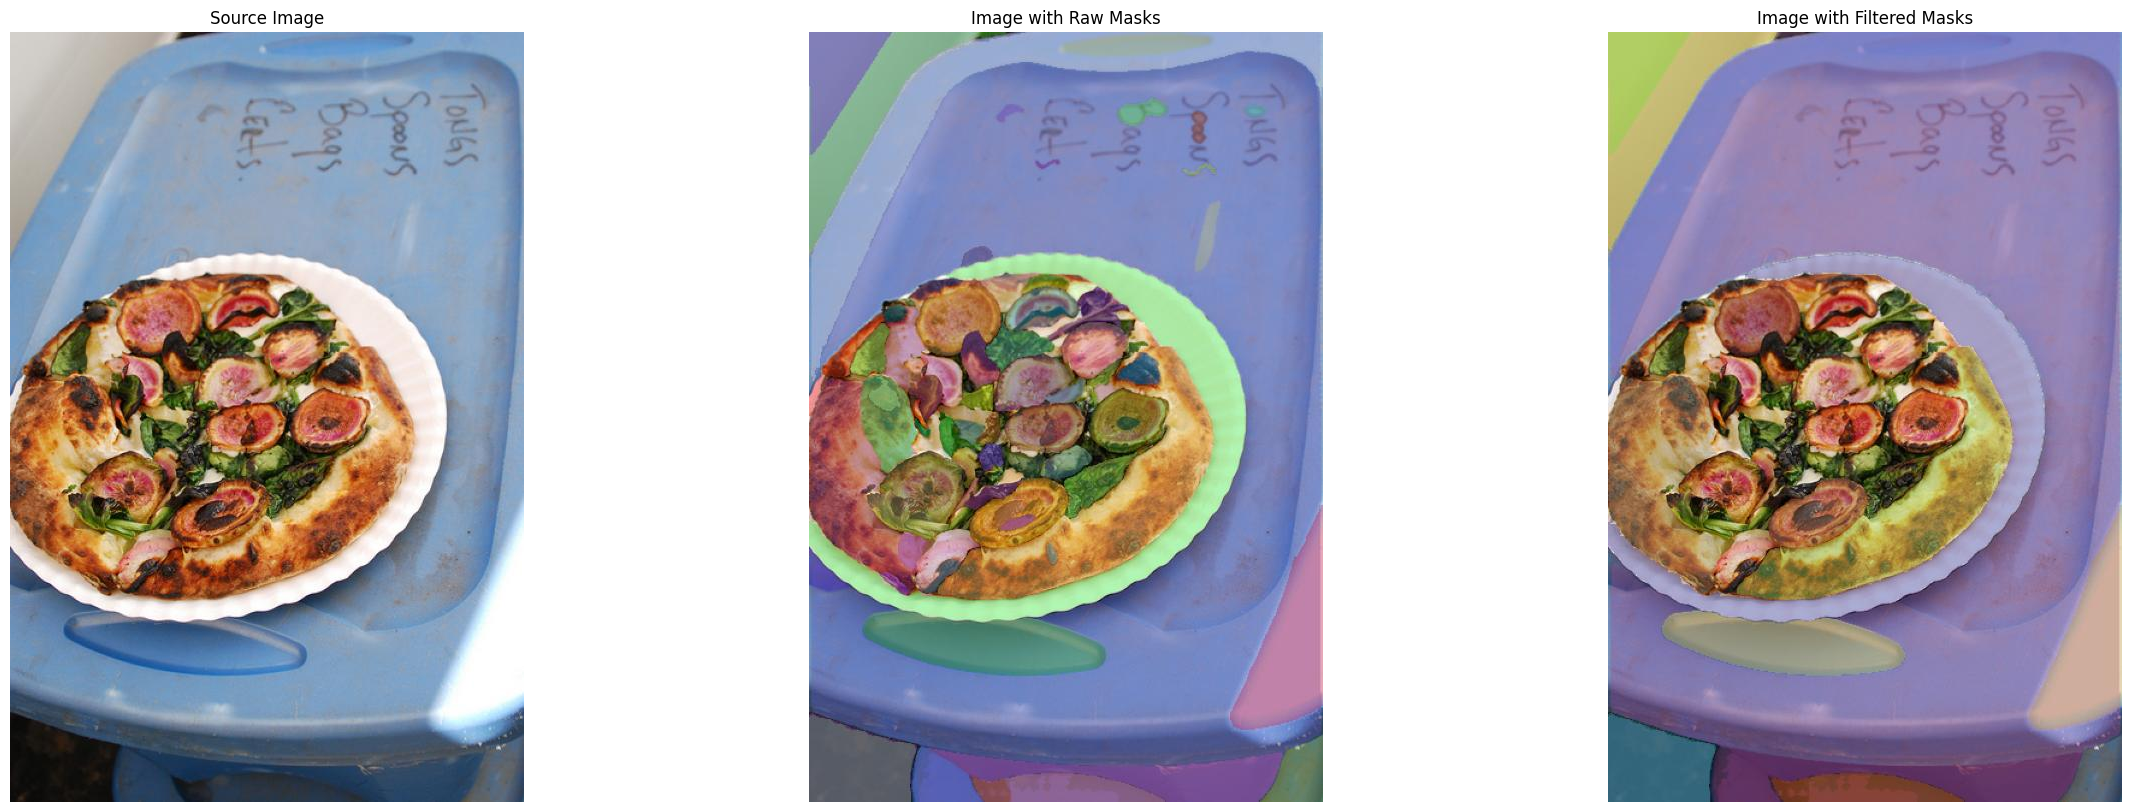

saving cropped mask image files...
[1/15]: pizza (99.79%)
[2/15]: pizza (98.71%)
[3/15]: pizza (99.85%)
[4/15]: pizza (99.92%)
[5/15]: pizza (99.96%)
[6/15]: pizza (99.84%)
[7/15]: boat (78.65%)
[8/15]: sink (82.76%)
[9/15]: banana (16.38%)
[10/15]: boat (89.70%)
[11/15]: boat (34.12%)
[12/15]: book (88.10%)
[13/15]: pizza (76.15%)
[14/15]: remote (14.27%)
[15/15]: pizza (89.40%)
image ID: 179214 category ID: 59


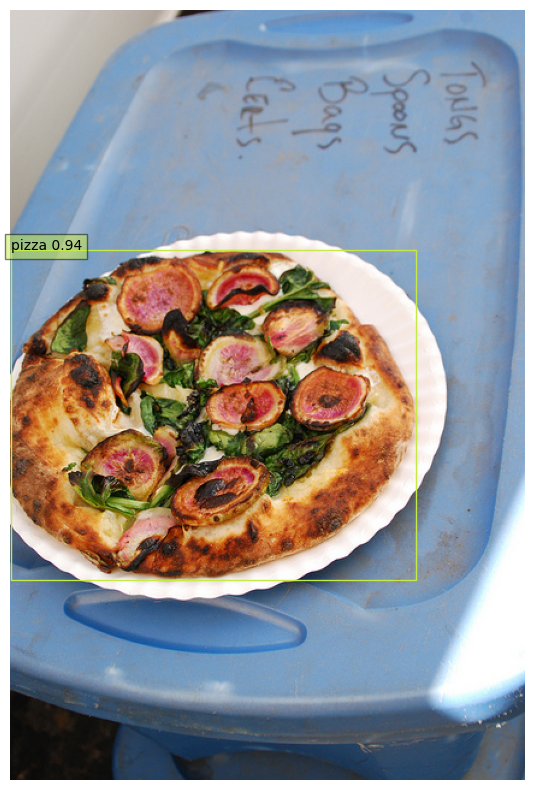

In [13]:
# create output folder for this image
image_folder_path = f"../output"
if not os.path.exists(image_folder_path):
    os.mkdir(image_folder_path)

image = io.imread(image_link)
height, width = image.shape[:2]
imageArea = height * width
maskArea = 0.01 * imageArea

# save original image for future analysis
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.savefig(f"../output/source.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

raw_masks = generate_masks(image)    
if VERBOSE_LOGGING:
    print(f"generated {len(raw_masks)} masks...")
    
filtered_masks = filter_masks(raw_masks, maskArea)
if VERBOSE_LOGGING:
    print(f"masks filtered down to {len(filtered_masks)} masks...")

plt.figure(figsize=(10, 10))
plt.imshow(image)

if VERBOSE_LOGGING:
    print("applying raw masks on source image...")

show_anns(raw_masks)
plt.axis('off')
plt.savefig(f"../output/generated-raw-masks.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

plt.figure(figsize=(10, 10))
plt.imshow(image)

if VERBOSE_LOGGING:
    print("applying filtered masks on source image...")
    
show_anns(filtered_masks)
plt.axis('off')
plt.savefig(f"../output/generated-filtered-masks.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

source_image = io.imread(f"../output/source.jpg")
fig, axs = plt.subplots(1, 3,figsize=(30, 10))
axs[0].imshow(source_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Source Image")
masked_image = io.imread(f"../output/generated-raw-masks.jpg")
axs[1].imshow(masked_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Image with Raw Masks")
masked_image = io.imread(f"../output/generated-filtered-masks.jpg")
axs[2].imshow(masked_image, cmap='gray')
axs[2].axis('off')
axs[2].set_title("Image with Filtered Masks")
plt.subplots_adjust(wspace=0.1)
plt.show()
plt.close()

if VERBOSE_LOGGING:
    print("saving cropped mask image files...")
# save mask image files
save_raw_mask_images(image, raw_masks)
save_mask_images(image, filtered_masks)

# print(f"({image_index}): generating labels...")
generated_labels, generated_probs = generate_labels(filtered_masks)

plt.figure(figsize=(10, 10))
plt.imshow(image)
shows_masks_with_labels(filtered_masks, generated_labels, generated_probs)
plt.axis('off')
plt.savefig(f"../output/generated-masks-labels.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

infer_model(image=image_link)

clean_generated_labels = list(set(generated_labels)) # removes duplicates, if any


if input_mode == "random":
    print("image ID:", image_ID, "category ID:", image_category_ID)
    annIds = coco_caps.getAnnIds(imgIds=image_ID)
    anns = coco_caps.loadAnns(annIds)
    ground_truth_labels = []
    ground_truth = []
    for ann in anns:
        ground_truth_labels.append(ann['caption'])
        words = ann['caption'].split()
        for word in words:
            ground_truth.append(word.lower())
    ground_truth_values = list(set(ground_truth))

    # for each mask image, annotate using open-clip
    save_labels(filtered_masks, generated_labels, generated_probs)
 
    ground_truth_string = " ".join(ground_truth_labels)
    
    top_one_scores.append(clean_generated_labels[0] in ground_truth_string)
    top_five_scores.append(isTopNAccurate(
        clean_generated_labels, ground_truth_string))

In [14]:
if (input_mode == "random"):    
    json_object = json.dumps(coco_results, indent=4)
    with open("../output/results.json", "w") as outfile:
        outfile.write(json_object)
    cocoDt = cocoGt.loadRes("../output/results.json")
    cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
    cocoEval.params.imgIds = [image_ID]
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

In [15]:
print("GENERATED LABELS")
pprint(clean_generated_labels)
if (input_mode == "random"):
    print("GROUND TRUTH LABELS")
    pprint(ground_truth_labels)

if (input_mode == "random"):  
    print("-------------------------")
    print("op-1 Accuracy SCORE")
    top_one_score = top_one_scores.count(True)/len(top_one_scores)
    print(top_one_score)
    print("Top-5 Accuracy SCORE")
    top_five_score = top_five_scores.count(True)/len(top_five_scores)
    print(top_five_score)

GENERATED LABELS
['pizza', 'boat', 'sink', 'remote', 'book', 'banana']
GROUND TRUTH LABELS
['A white plate topped with a pizza and cheese.',
 'A pizza with several vegetable toppings sitting on a storage tub.',
 'The gourmet pizza includes several very special ingredients.',
 'A blue bin with a pizza on a plate with toppings on top of it.',
 'a small pizza on a paper plate ']
-------------------------
op-1 Accuracy SCORE
1.0
Top-5 Accuracy SCORE
1.0


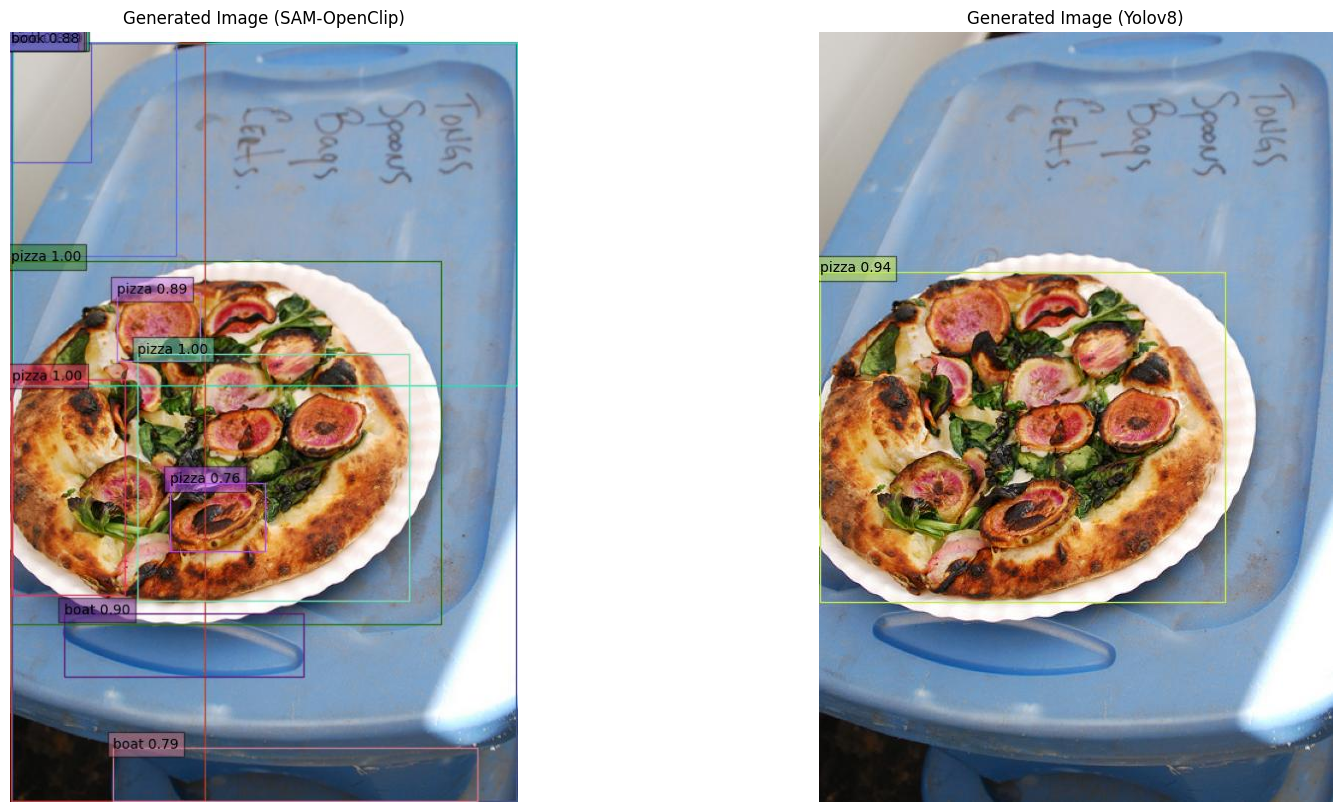

In [16]:

generated_image = io.imread(f"../output/generated-masks-labels.jpg")
fig, axs = plt.subplots(1, 2,figsize=(20, 10))
axs[0].imshow(generated_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Generated Image (SAM-OpenClip)")
yolo_image = io.imread(f"../output/yolo-masks-labels.jpg")
axs[1].imshow(yolo_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Generated Image (Yolov8)")
plt.subplots_adjust(wspace=0.1)
plt.show()
plt.close()